In [2]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import ADASYN

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob

2023-05-12 11:08:18.540647: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df = pd.read_csv("labels-map-proj_v3_2.txt", sep=" ", header=None, names=["image", "label"])
df.head()

,image,label
0,ESP_013049_0950_RED-0067.jpg,7
1,ESP_013049_0950_RED-0067-fv.jpg,7
2,ESP_013049_0950_RED-0067-brt.jpg,7
3,ESP_013049_0950_RED-0067-r90.jpg,7
4,ESP_013049_0950_RED-0067-r180.jpg,7


In [4]:
df["label"].value_counts() # need to include imbalance handling

label
0    52722
1     5024
6     1834
4     1654
3     1575
7      896
2      766
5      476
Name: count, dtype: int64

In [29]:
def load_images_labels_from_df(df, folder, number_of_images=1000):
    shuffled_indices = np.random.permutation(len(df)) # indices in shuffled order
    
    # get thos values from df that are in the shuffled_indices list
    df = df.iloc[shuffled_indices[:number_of_images]]
    print("Drawn distribtuion of images:")
    print(df["label"].value_counts())
    images = []
    labels = []
    for i in range(len(df)):
        img = cv2.imread(folder+"/"+df.iloc[i][0])
        if img is not None:
            images.append(img)
            labels.append(df.iloc[i][1])
    return np.array(images), np.array(labels)

In [30]:
X, y = load_images_labels_from_df(df, "map-proj-v3_2")

Drawn distribtuion of images:
label
0    803
1     80
3     31
4     30
6     22
2     15
7     13
5      6
Name: count, dtype: int64


In [38]:
print(X.shape)
X_reshaped = X.flatten().reshape(1000, 154587)
print(X_reshaped.shape)

(1000, 227, 227, 3)
(1000, 154587)


In [40]:
adasyn = ADASYN(sampling_strategy="not majority", random_state=42)
X_res, y_res = adasyn.fit_resample(X_reshaped, y)

In [46]:
print(X_res.shape)
unique, counts = np.unique(y_res, return_counts=True)
unique, counts

(6455, 154587)


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([803, 810, 805, 811, 810, 804, 806, 806]))

In [47]:
X_reshaped_reshaped = X_res.reshape(6455, 227, 227, 3)
X_reshaped_reshaped.shape

(6455, 227, 227, 3)

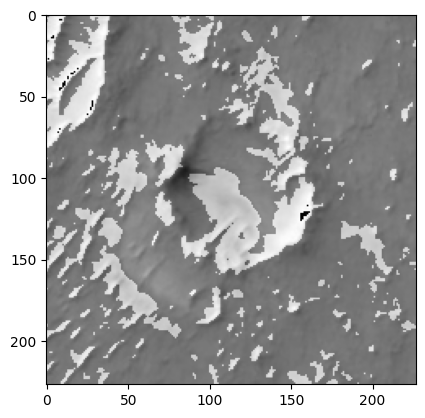

In [61]:
plt.imshow(X_reshaped_reshaped[1032])

In [96]:
df.iloc[0][0], df.iloc[0][1]

('ESP_013049_0950_RED-0067.jpg', 7)

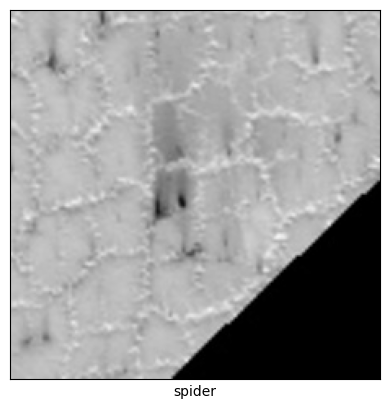

In [97]:
class_names = ["other", "crater", "dark dune", "slope streak", "bright dune", "impact ejecta", "swiss cheese", "spider"]

plt.imshow(cv2.imread("map-proj-v3_2/" + df.iloc[0][0]))
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.xlabel(class_names[df.iloc[0][1]])
plt.show()

In [98]:
def split_train_test(data, folder, test_ratio, number_of_images):
    shuffled_indices = np.random.permutation(len(data)) # indices in shuffled order
    test_set_size = int(len(data) * test_ratio) # size of test set
    
    train = data.iloc[shuffled_indices[:test_set_size]] # first x rows of data (train set)
    test = data.iloc[shuffled_indices[test_set_size:]] # last x rows of data (test set)

    train_images = []
    train_labels = []
    test_images = []
    test_labels = []

    for i in range(len(train)):
        if i == number_of_images:
            break
        img = cv2.imread(folder+"/"+train.iloc[i][0])
        if img is not None:
            train_images.append(img)
            train_labels.append(train.iloc[i][1])
    for i in range(len(test)):
        if i == number_of_images:
            break
        img = cv2.imread(folder+"/"+test.iloc[i][0])
        if img is not None:
            test_images.append(img)
            test_labels.append(test.iloc[i][1])

    return np.array(train_images), np.array(train_labels), np.array(test_images), np.array(test_labels)

In [99]:
train_images, train_labels, test_images, test_labels = split_train_test(df, "map-proj-v3_2/", 0.2, 100)
print("train images:", type(train_images), "\ntest images:", type(test_images), # numpy arrays of images
      "\ntrain labels:", type(train_labels), "\ntest labels:", type(test_labels)) # lists of labels

print(train_labels[:5]) # 5 labels
print(train_images.shape) # 100 images, 256x256, 3 channels

train images: <class 'numpy.ndarray'> 
test images: <class 'numpy.ndarray'> 
train labels: <class 'numpy.ndarray'> 
test labels: <class 'numpy.ndarray'>
[0 4 0 0 0]
(100, 227, 227, 3)


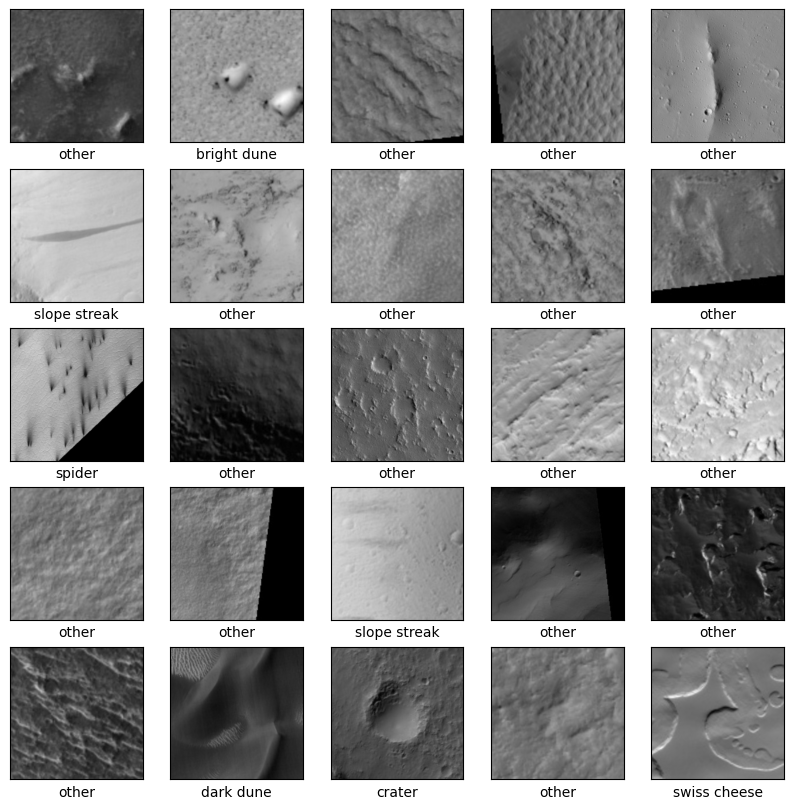

In [100]:
class_names = ["other", "crater", "dark dune", "slope streak", "bright dune", "impact ejecta", "swiss cheese", "spider"]

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i]) # cmap=plt.cm.binary
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [101]:
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 5, activation="relu", padding="same",
                        input_shape=(227,227,3)),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(8, activation="softmax")
])

In [102]:
# display the architecture of model
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 227, 227, 64)      4864      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 113, 113, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 113, 113, 128)     73856     
                                                                 
 conv2d_20 (Conv2D)          (None, 113, 113, 128)     147584    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 56, 56, 256)      

In [103]:
# Compile and train the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10


/Users/finnfeddersen/Documents/SynologyDrive/01 Data Science/2. Semester/04 Machine Learning/Final Project v2/.venv/lib/python3.8/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


4/4 [==============================] - 48s 11s/step - loss: 352.0196 - accuracy: 0.4000 - val_loss: 21.1978 - val_accuracy: 0.7500
Epoch 2/10
4/4 [==============================] - 49s 12s/step - loss: 14.6215 - accuracy: 0.2900 - val_loss: 25.0701 - val_accuracy: 0.7500
Epoch 3/10
4/4 [==============================] - 43s 11s/step - loss: 15.7373 - accuracy: 0.5200 - val_loss: 2.3088 - val_accuracy: 0.7500
Epoch 4/10
4/4 [==============================] - 40s 10s/step - loss: 1.4022 - accuracy: 0.8400 - val_loss: 6.8455 - val_accuracy: 0.7500
Epoch 5/10
4/4 [==============================] - 41s 10s/step - loss: 2.6034 - accuracy: 0.8400 - val_loss: 1.4439 - val_accuracy: 0.7500
Epoch 6/10
4/4 [==============================] - 40s 10s/step - loss: 1.4645 - accuracy: 0.8500 - val_loss: 3.5526 - val_accuracy: 0.7500
Epoch 7/10
4/4 [==============================] - 43s 11s/step - loss: 1.6679 - accuracy: 0.8400 - val_loss: 1.2625 - val_accuracy: 0.7500
Epoch 8/10
4/4 [================

4/4 - 10s - loss: 1.7525 - accuracy: 0.7500 - 10s/epoch - 2s/step
0.75


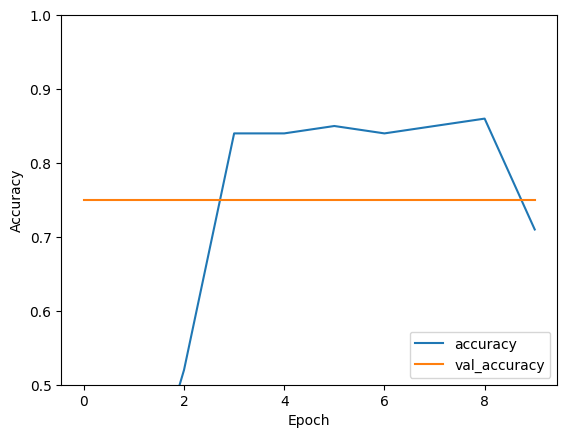

In [104]:
# Evaluate the model
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(test_acc)

In [110]:
y_pred_prob = model.predict(test_images)
y_pred_class = y_pred_prob.argmax(axis=-1)
print(test_images.shape)
print(y_pred_prob.shape)
print(y_pred_class.shape)

4/4 [==============================] - 14s 3s/step
(100, 227, 227, 3)
(100, 8)
(100,)


In [112]:
print(y_pred_prob[0])
print(y_pred_class[0])

[9.9999994e-01 2.6889354e-11 8.3544468e-17 4.7753709e-17 5.1388053e-17
 1.1390982e-16 7.6560248e-13 1.3972278e-18]
0


In [125]:
print(np.unique(test_labels))
print(np.unique(y_pred_class))

[0 1 2 3 4 6 7]
[0]


In [119]:
#print(class_names)
print(classification_report(y_pred_class, test_labels))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86       100
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0

    accuracy                           0.75       100
   macro avg       0.14      0.11      0.12       100
weighted avg       1.00      0.75      0.86       100



/Users/finnfeddersen/Documents/SynologyDrive/01 Data Science/2. Semester/04 Machine Learning/Final Project v2/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/finnfeddersen/Documents/SynologyDrive/01 Data Science/2. Semester/04 Machine Learning/Final Project v2/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/finnfeddersen/Documents/SynologyDrive/01 Data Science/2. Semester/04 Machine Learning/Final Project v2/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344:

model = models.Sequential()

# Convolutional Base
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(227, 227, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Dense Layer ontop
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(8), activation='softmax')

# OLD CODE

------------------------------------------------------------------------------------------------

def load_images_from_folder_excel(folder, mapping, number_of_images):
    images = []
    labels = []
    for i in range(len(mapping)):
        if i == number_of_images:
            break
        img = cv2.imread(folder+"/"+mapping.iloc[i][0])
        if img is not None:
            images.append(img)
            labels.append(mapping.iloc[i][1])
    return images, labels

train_images, train_labels = load_images_from_folder_excel("map-proj-v3_2", mapping, 100)
print(len(train_images))
print(train_labels[:5])
print(train_images[:5])